# TensorFlow Optimized Single-Layer Perceptron

Since I really do not want to re-write the binary classifier from `A1 SLP Gradient Descent`, I am going to re-implement it using a TensorFlow optimizer (SGD). 

## Todo
 - [x] Get data, convert to tensor.
 - [x] Loss function, re-implemented using Tensors.
 - [x] Accuracy function, re-implemented using Tensors (or just convert...).
 - [x] Gradient descent function.
 - [x] Plots.
 - [x] Caching (see MLP gradient descent).

In [383]:
# IMPORT BOX #
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tqdm.notebook import tqdm # Progress bars

## Data Loading Functions

In [384]:
# Load the data
def loadData():
    with np.load("../datasets/notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(5213)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        print("DATA DIMENSIONS: ", Data.shape)
        # 14043 = 18724*.75
#         trainData, trainTarget = Data[:10000], Target[:10000]
#         validData, validTarget = Data[10000:16000], Target[10000:16000]
#         testData, testTarget = Data[16000:], Target[16000:]
        trainData, trainTarget = Data[:14043], Target[:14043]
        validData, validTarget = Data[14043:], Target[14043:]
        testData, testTarget = Data[14043:], Target[14043:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [385]:
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [386]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

## Loading Data

In [387]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)

trainData = trainData.reshape(14043, 784)
validData = validData.reshape(validData.shape[0], 784)
testData = testData.reshape(testData.shape[0], 784)

trainData = np.transpose(trainData)
validData = np.transpose(validData)
testData = testData.T

y_train = np.transpose(newtrain)
y_valid = np.transpose(newvalid)
y_test = np.transpose(newtest)

print("Training data shape: \t{}".format(trainData.shape))
print("Validation data shape: \t{}".format(validData.shape))

DATA DIMENSIONS:  (18724, 28, 28)
Training data shape: 	(784, 14043)
Validation data shape: 	(784, 4681)


## Tensor Conversion

In [388]:
T_y_train = tf.constant(y_train)
T_y_valid = tf.constant(y_valid)
T_trainData = tf.constant(trainData)
T_validData = tf.constant(validData)

## Variables

In [389]:
w = np.random.random(size=(10, 28*28))*2-1
W = tf.Variable(w)
b = np.zeros(shape=(10,1))
B = tf.Variable(b)

In [390]:
W.shape

TensorShape([10, 784])

In [391]:
B.shape

TensorShape([10, 1])

In [392]:
T_trainData.shape

TensorShape([784, 14043])

In [393]:
test_pred = W @ T_trainData + B

In [394]:
test_pred.shape

TensorShape([10, 14043])

In [395]:
T_y_train.shape

TensorShape([10, 14043])

## Helper Functions

In [396]:
def forward(W, B, X):
    # Matrix multiply, add bias
    pred = W @ X + B
    # Softmax: Subtract each column's maximum from the corresponding column.
    maxes = tf.math.reduce_max(pred, axis=0, keepdims=True)
    pred -= maxes
    # Softmax: Exponentiate the whole thing.
    pred = tf.math.exp(pred)
    # Softmax: Divide each column by each column's sum.
    col_sums = tf.math.reduce_sum(pred, axis=0, keepdims=True)
    col_sums = tf.constant(np.ones(shape=(10,1))) @ col_sums
    return tf.divide(pred, col_sums)

In [397]:
def CE(targets, predictions):
    return tf.math.reduce_sum(targets*tf.math.log(predictions))*-1
    
def averageCE(targets, predictions):
    return (1./targets.shape[1]) * CE(targets, predictions)

In [398]:
def get_accuracy(targets, predictions):
    targmax = tf.math.argmax(targets, axis=0)
    predmax = tf.math.argmax(predictions, axis=0)
    
    bool_ary = targmax==predmax
    int_ary = tf.cast(bool_ary, dtype=tf.int32)
    
    correct = tf.math.reduce_sum(int_ary).numpy()
    total = targmax.shape[0]
    return correct/total

In [399]:
test_out = forward(W, B, T_trainData)

In [400]:
get_accuracy(T_y_train, test_out)

0.10553300576799829

## Optimization

In [401]:
iterations = 5000
learning_rate = 0.1

In [402]:
def minimize_me():
    return averageCE(T_y_train, forward(W,B,T_trainData))

In [403]:
# Create an optimizer with the desired parameters.
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# In eager mode, simply call minimize to update the list of variables.
losses = [minimize_me().numpy()]
valid_losses = [averageCE(T_y_valid, forward(W,B,T_validData)).numpy()]
accuracies = [get_accuracy(T_y_train, forward(W,B,T_trainData))]
valid_accuracies = [get_accuracy(T_y_valid, forward(W,B,T_validData))]

for iteration in tqdm(range(iterations)):
    # OPTIMIZATION STEP
    opt.minimize(minimize_me, var_list=[W,B])
    # Logistical Maintenance
    losses.append(minimize_me().numpy())
    valid_losses.append(averageCE(T_y_valid, forward(W,B,T_validData)).numpy())
    accuracies.append(get_accuracy(T_y_train, forward(W,B,T_trainData)))
    valid_accuracies.append(get_accuracy(T_y_valid, forward(W,B,T_validData)))
    

  0%|          | 0/5000 [00:00<?, ?it/s]

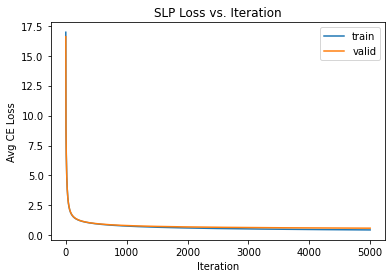

In [404]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.title('SLP Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg CE Loss')
plt.legend()
plt.show()

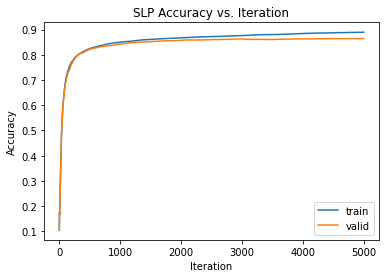

In [405]:
plt.plot(accuracies, label='train')
plt.plot(valid_accuracies, label='valid')
plt.title('SLP Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [406]:
valid_accuracies[-1]

0.8645588549455244

In [407]:
accuracies[-1]

0.8896959339172541

## Caching Results

In [408]:
import uuid
import json
import pickle

output_path = "../results/final/OCR/gradient_descent/"

In [409]:
out_name = "{}".format(uuid.uuid1())
# Printing random id using uuid1()
print ("The random id using uuid1() is : ",end="")
print (out_name)

The random id using uuid1() is : d5dc35ce-bea2-11eb-9153-f2189895db64


In [410]:
output_dict = {
    "learning_rate": learning_rate,
    "momentum": 0,
    "hidden_units": 0,
    "save_name": "{}.json".format(out_name),
    "losses": losses,
    "valid_losses": valid_losses,
    "accuracies": accuracies,
    "valid_accuracies": valid_accuracies,
    "train_probabilities": forward(W,B,T_trainData),
    "valid_probabilities": forward(W,B,T_validData),
    "train_labels": T_y_train,
    "valid_labels": T_y_valid,
    "iters": iterations
}


In [411]:
PTH = "{}{}.pkl".format(output_path, out_name)
PTH

'../results/final/OCR/gradient_descent/d5dc35ce-bea2-11eb-9153-f2189895db64.pkl'

In [412]:
serialized = pickle.dumps(output_dict)

In [413]:
with open(PTH, 'wb') as handle:
    pickle.dump(output_dict, handle)

In [414]:
with open(PTH, 'rb') as handle:
    b = pickle.load(handle)

In [415]:
type(b['train_labels']) # Type test.

tensorflow.python.framework.ops.EagerTensor